# Hexagon tile grid map generator 
***
#### This Python project automates the creation of hexagon tile grid maps for any geospatial polygon input *.  
For example:

<img src="USA_hexes_and_states.png">

_* This code has not been thoroughly tested. Please feel free to contribute, suggest improvements, or let me know where your application of this code breaks so I can make it better._

#### The workflow of this code is generally:
1. Read in a polygon layer using GeoPandas, creating a GeoDataFrame (i.e. a GDF).
2. Add centroid geometry to each polygon in the GDF.
3. Generalize the polygon geometries by creating convex hulls.
4. Create another GDF with the dissolved convex hull geometries. This creates a single polygon feature, representing a generalized outline of the input features. This is later used when creating hexagons.
5. Add centroid geometry to the generalized outline.
6. Calculate the minimum bounding rectangle, to determine hexagon creation start point.
7. Create a seed hexagon in the lower left corner or the bouding rectangle.
8. Copy that hexagon, shifting it in the X and Y directions so that it forms a seamless hexagon grid.
9. Keep only the hexagons that have their centroid within the generalized outline of the features.
10. If the number of hexagons created does not equal the number of polygons in the input data, alter the size of the hexagons and try again. 
11. The final product can be output to any geospatial format (Shapefile, GeoJSON, etc.).


In [5]:
import os
import sys
import math
import operator
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import gridmap_refactor_config as c

from IPython.display import display, HTML
from tabulate import tabulate
from shapely.geometry import Polygon, Point
from math import sqrt
from shapely.affinity import translate

### Define variables for input data, field names, etc.
***
#### The first group is field names (i.e. attributes) that will be added to input data (i.e. GeoPandas GeoDataFrames). 
These shouldn't need to be changed
#### The second group is specific to input data. Define:
* Input data layer (shapefile, geojson, etc.).
* Attribute name holding administrative names or codes.
* Attribute names to not get rid of in input data (for minimizing data size).
* EPSG code, if you have one. If you don't specify one, data will be read in with any existing spatial reference.

In [6]:
# Attribute names to add to geodataframe during processing
tile_id = 'tile_id'
admin_id = 'admin_id'
admin_id_admin = 'admin_id_admin'
admin_id_tile = 'admin_id_tile'
jo_tile = 'join_order_tile'
jo_admin = 'join_order_admin'


# Variable names for input data

## Kenya
polys = c.kenya_counties
admin_name_col = 'County'
keep_flds = ['County', admin_id]
epsg = 32662

## USA
# polys = c.USA_extraSimp
# admin_name_col = 'HASC_1'
# keep_flds = ['NAME_1', admin_id]
# epsg = 5070

## India
# polys = c.india
# admin_name_col = 'AREA_NAME'
# keep_flds = ['AREA_NAME', admin_id]
# epsg = 4240

### Verify that the file path is a valid file

In [7]:
os.path.isfile(polys)

True

### Define a function to read a geospatial file into a GeoDataFrame
* This will attempt to reproject the file to your specified EPSG spatial reference
* If the reprojection fails, it will default to the spatial reference defined in the input data

In [8]:
def read_file_and_attempt_projection(file, epsg_code):
    try:
        gdf = gpd.read_file(file).to_crs({'init': 'epsg:{}'.format(epsg_code)})
        print('Data projected to EPSG code: {}'.format(epsg_code))
    except:
        gdf = gpd.read_file(file)
        print('*** Failed to project to EPSG code: {} \
              \n*** Data read in with this CRS: {}'.format(epsg_code, gdf.crs))
    return gdf

### Read geospatial file to a GeoDataFrame, sort by admin name/code, remove unwanted fields

In [9]:
admin = read_file_and_attempt_projection(polys, epsg)

#admin[admin_id] = admin[admin_name_col].str.split('.').str[1] #For USA
#admin[admin_id] = admin[admin_name_col].str.split(' ').str[0] #For India
admin[admin_id] = admin[admin_name_col] #For Kenya

admin = admin.sort_values(by=admin_name_col).reset_index(drop=True)
admin = admin.rename(columns={'geometry': 'geom_poly'}).set_geometry('geom_poly')
keep_flds.append(admin.geometry.name)
del_flds = [x for x in list(admin) if x not in keep_flds]
admin.drop(columns=del_flds, inplace=True)
print(display(HTML(admin.head(5).to_html())))

Data projected to EPSG code: 32662


,County,geom_poly,admin_id
0,BARINGO,"POLYGON ((3983326.690146697 184294.7525514657,...",BARINGO
1,BOMET,POLYGON ((3931518.287214297 -46478.28556197786...,BOMET
2,BUNGOMA,"POLYGON ((3853888.963709745 122477.0857682176,...",BUNGOMA
3,BUSIA,(POLYGON ((3775250.306048207 11380.62424266465...,BUSIA
4,ELGEYO MARAKWET,"POLYGON ((3967239.171704703 92946.86027951103,...",ELGEYO MARAKWET


None


### Define useful functions, and run them.
#### Create geometries for later spatial comparisons
* Add centroid geometry to each polygon

#### Create generalized bounding geometry, to later ensure that hexagons conform to input data shape
* Create convex hull geometry (i.e. minimum bounding geometry)
* Dissolve convex hull geometry to a single polygon

In [10]:
def display_point_labels(gdf, label_col, fs=10, c='blue', angle=0):
    texts = []
    for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf[label_col]):
        texts.append(plt.text(x, y, label, fontsize=fs, color=c, rotation=angle, 
                              horizontalalignment='center', verticalalignment='center'))

def add_centroid_geom(gdf):
    gdf['geom_centroid'] = gdf.centroid
    return gdf

def add_convexhull_geom(gdf):
    gdf['geom_convexhull'] = gdf.convex_hull
    return gdf

def dissolve_polygons(gdf):
    gdf['dissolve_col'] = 1
    gdf_dissolve = gdf.dissolve(by='dissolve_col')
    #gdf_dissolve['geom_exterior'] = Polygon(gdf_dissolve.exterior[1])
    #gdf_dissolve = gdf_dissolve.set_geometry('geom_exterior')
    gdf_dissolve['geom_centroid'] = gdf_dissolve.centroid
    return gdf_dissolve.reset_index(drop=True)

admin = add_centroid_geom(admin)
admin = add_convexhull_geom(admin)
admin_hulls_dissolved = dissolve_polygons(admin.set_geometry('geom_convexhull'))

print(display(HTML(admin_hulls_dissolved.to_html())))

,geom_convexhull,County,geom_poly,admin_id,geom_centroid
0,"POLYGON ((4365643.74371506 -520680.4985606369,...",BARINGO,"POLYGON ((3983326.690146697 184294.7525514657,...",BARINGO,POINT (4215163.450613908 72460.39031189201)


None


### Display admin polygons and centroids

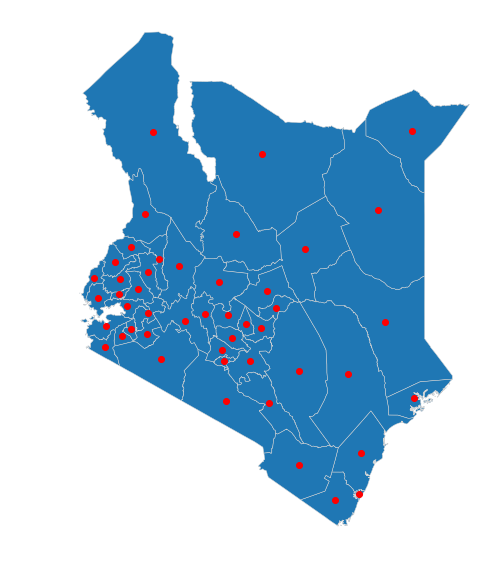

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

# Plot on axis 1 (left)
ax.set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax, linewidth=0.5, edgecolor='lightgrey')
admin.set_geometry('geom_centroid').plot(ax=ax, color='red')

plt.show()

### Display convex hulls and bounding geometry

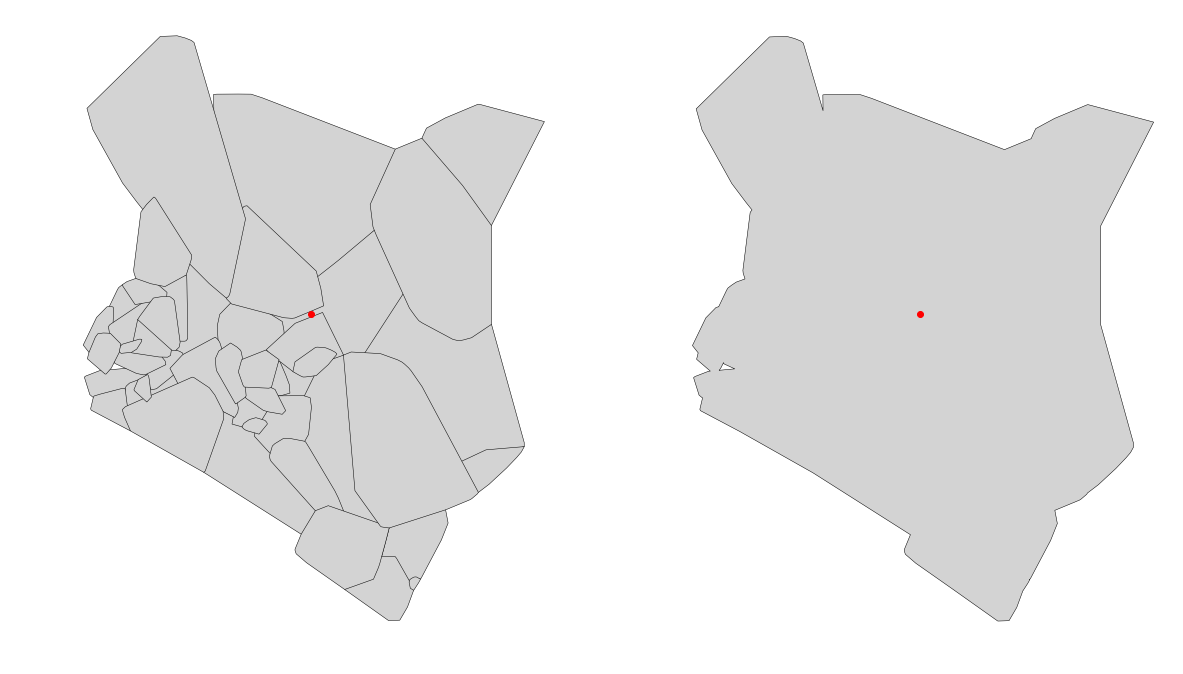

In [12]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 20), sharex=True, sharey=True)

# Plot on axis 1 (left)
ax1.set_axis_off()
admin.set_geometry('geom_convexhull').plot(ax=ax1, linewidth=0.5, edgecolor='black', color='lightgrey')
admin_hulls_dissolved.set_geometry('geom_centroid').plot(ax=ax1, color='red')

# Plot on axis 2 (right)
ax2.set_axis_off()
admin_hulls_dissolved.plot(ax=ax2, linewidth=0.5, edgecolor='black', color='lightgrey')
admin_hulls_dissolved.set_geometry('geom_centroid').plot(ax=ax2, color='red')
#admin.loc[admin[admin_id] == 'ME'].set_geometry('geom_centroid').plot(ax=ax2, color='black') # Only for USA

plt.show()

### Functions to get some basic data extent information

In [13]:
def round_dict_vals(dictionary, places=10):
    for k, v in dictionary.items():
        dictionary[k] = float(round(dictionary[k], places))
    return dictionary

def get_bounding_coordinates(gpd, round_nums=True):
    tb = gpd.total_bounds
    total_bounds = {'minx': tb[0],
                    'miny': tb[1],
                    'maxx': tb[2],
                    'maxy': tb[3],
                    'rangex': abs(tb[0] - tb[2]),
                    'rangey': abs(tb[1] - tb[3])}
    if round_nums:
        total_bounds = round_dict_vals(total_bounds)
    
    return total_bounds

def build_bounding_polygon(extent, crs):
    BL = (extent['minx'], extent['miny'])
    BR = (extent['maxx'], extent['miny'])
    TR = (extent['maxx'], extent['maxy'])
    TL = (extent['minx'], extent['maxy'])
    corners = [BL, BR, TR, TL]
    rectangle = gpd.GeoDataFrame(pd.DataFrame({'geometry': [Polygon(corners)]}), geometry='geometry', crs=crs)
    
    return rectangle
    
bbox = get_bounding_coordinates(admin.set_geometry('geom_poly'))
bbox_gdf = build_bounding_polygon(bbox, admin.crs)
bbox

{'minx': 3774805.2726539546,
 'miny': -520680.4985606369,
 'maxx': 4665640.106978698,
 'maxy': 608975.269118562,
 'rangex': 890834.8343247436,
 'rangey': 1129655.7676791989}

## Functions that actually create hexagons 
#### Function: displace_vertex
* This function displaces a point at a given distance and angle. 
* 6 points creates the vertices for a hexagon.

#### Function: build hexagon
* This function calls the *displace_vertex* function 5 times to create 5 points in addition to the starting point
* Then connects those vertices to create a polygon

#### Function: tesselate_hexagons_translate
* This function uses the single hexagon created previously, copies it, and translates it (i.e. slides it) in the x direction, creating a row.
* When the row is complete, it starts back at the original hexagon and translates it in the x and y directions to create the first hexagon in the next row.
* This repeats until both the x and y dimensions have been filled wit hexagons.

#### Function: iterate_size
* This function iteratively changes (decreases) the size of the hexagons until the number of hexagons created matches, or is less than, the number of administrative areas in the input data

#### Function: verify_count
* This is a simple function to print a statement indicating if the number of hexagons created is correct, or if there are too few.
* If there are too few, it is suggested that the user alter some of the parameters


In [14]:
def displace_vertex(x, y, length, angle):
    '''
    calculates new point up to a given distance away
    from original point. All values should be provided
    in meters

    point = (x,y)
    '''
    #The number pi
    PI = 3.1415926535

    #Convert the random angle from degrees to radians
    angle_radian = (angle) * (PI/180)

    #Generate the offset by applying trig formulas (law of cosines) 
    #using the distance as the hypotenuse solving for the other sides
    xOffset = math.sin(angle_radian) * length
    yOffset = math.cos(angle_radian) * length

    #Add the offset to the orginal coordinate
    new_x = x + xOffset
    new_y = y + yOffset

    return (new_x, new_y) 

def build_hexagon(x, y, length, bearing):
    pts = [(x,y)]
    
    for pt in range(0,5):
        x, y = displace_vertex(x, y, length, bearing)
        bearing += 60
        pts.append((x,y))
    hex_poly = Polygon(pts)
    return hex_poly

def tesselate_hexagons_translate(bb, hull, length, x_offset_factor, y_offset_factor, flat, keep):
    x_row = 100
    y_col = 0
    hexes = []
    x_offset_seed = x_offset_factor * length
    y_offset_seed = y_offset_factor * length
    
    # flat='up' means flat sides are up and down
    # flat='side' means flat sides are on the sides
    if flat=='up':
        bearing = 30
        next_start_pt_idx = 3
    elif flat=='side':
        bearing = 0
        next_start_pt_idx = 4
    else:
        raise Exception('Acceptable parameters for flat: \'up\' and \'side\'')
    
    hexagon_seed = build_hexagon(bb['minx'] + x_offset_seed, bb['miny'] + y_offset_seed, length, bearing)
    hexagon = hexagon_seed
    
    row=1
    shift = 1
    xy_inside_bbox = True
    while xy_inside_bbox:
        y_col += 1
        hex_gdf = gpd.GeoDataFrame(pd.DataFrame({'geom_poly': [hexagon]}), geometry='geom_poly')
        hex_gdf[tile_id] = (x_row + y_col)
        centroid = hexagon.centroid

        x_inside = ((centroid.x >= bb['minx'] - abs(x_offset_seed)) and
                    (centroid.x <= bb['maxx'] + abs(x_offset_seed)))
        y_inside = ((centroid.y >= bb['miny'] - abs(y_offset_seed)) and
                    (centroid.y <= bb['maxy'] + abs(y_offset_seed)))
        
        if keep=='center_in' and hull.intersects(centroid):
            hexes += [hex_gdf]
        elif keep=='touches' and hull.intersects(hexagon):
            hexes += [hex_gdf]
        
        if x_inside and y_inside:
            if flat == 'up':     
                move_x = 3 * length
            elif flat == 'side': 
                move_x = sqrt(3) * length     
            move_y = 0
                
        elif not x_inside and y_inside:
            hexagon = hexagon_seed
            if flat == 'up':
                if row%2 == 0: #Every other row
                    move_y = (sqrt(3) * length * shift) + y_offset_seed
                    move_x = 0 + x_offset_seed
                    shift+=1 
                else:
                    move_y = (((sqrt(3) * length) * shift) - (0.5 * sqrt(3) * length))  + y_offset_seed
                    move_x = (length * 1.5) + x_offset_seed
           
            elif flat == 'side':
                if row%2 == 0: #Every other row
                    move_y = 1.5 * length * row
                    move_x = 0#  + x_offset_seed
                else:
                    move_y = 1.5 * length * row
                    move_x = -((0.5 * sqrt(3) * length))# + x_offset_seed)
            x_row += 100
            y_col = 0
            row+=1
            
        else:
            xy_inside_bbox = False
        
        hexagon = translate(hexagon, xoff=move_x, yoff=move_y)
    
    hexes_gdf = gpd.GeoDataFrame(pd.concat(hexes, ignore_index=True, sort=False), crs=hexes[0].crs, geometry='geom_poly')
    hexes_gdf = add_centroid_geom(hexes_gdf)
    return hexes_gdf
    
def iterate_size(adm, bb, flat, x_offset_factor, y_offset_factor, len_factor, iter_factor, keep='touches'): #x_offset_factor should be between -1 and 1
    length = bb['rangex'] / len_factor
    print('\nFlat side: {}'.format(flat))
    
    hex_count = len(adm) + 1
    i = 1
    while hex_count > len(adm):
        hexagons = tesselate_hexagons_translate(bb=bbox, 
                                                hull=admin_hulls_dissolved['geom_convexhull'][0], 
                                                length=length,
                                                x_offset_factor=x_offset_factor,
                                                y_offset_factor=y_offset_factor,
                                                flat=flat,
                                                keep=keep)
        hex_count = len(hexagons)
        
        print('i{} h{}...'.format(i, hex_count), end =' ')
        length = length * iter_factor
        i+=1
        hexagons.crs = adm.crs
        
    return hexagons

def verify_count(hexes, num): # hexes is passed in as a list of geodataframes
    print('\n')
    i=1
    for h in hexes:
        if len(h) == num:
            print('Cool, we got the correct number of hexagons, {}, for item #{}'.format(num, i))
        else:
            print('*** Dang, we got {} hexagons but needed {} for item #{}. Try increasing lfac variable, or decreasing ifac variable.'.format(len(h), num, i))
        
        i+=1

### Calling functions to create hexagons
***
#### Input parameters must be set
* **flat_side***: Determines the orientation of the hexagons. 
 * **'up'** means the hexagons will have the flat sides up and down
 * **'side'** means the hexagons will have the flat sides on the right and left
* **xofac***: x offset factor - determines the offset in the x direction for the seed hexagon
* **yofac***: y offset factor - determines the offset in the y direction for the seed hexagon
* **lfac**: length factor - determines the size of the first hexagon by dividing the extent width by lfac
* **ifac**: iteration factor - a value multiplied by the length of a hexagon to increase/decrease it's size iteratively until the correct number of hexagons are created

**This example creates two versions of hexagon maps. You can create more by creating additional *flat_side*, *xofac*, and *yofac* variables, then calling the *iterate_size* function additional times**


In [15]:
# Hexagon creation variables
flat_side1 = 'side' # Hexagon orientation, possible values: up, side
xofac1 = 0.2  # X offset factor 1 - moves seed hexagon in the X direction. Ideally between -1 and 1
yofac1 = 1.5  # Y offset factor 1 - moves seed hexagon in the Y direction. Ideally between -1 and 1

flat_side2 = 'side' # Hexagon orientation, possible values: up, side
xofac2 = 0.5    # X offset factor 2 (if calling 'iterate_size' function a second time)
yofac2 = 1    # Y offset factor 2 (if calling 'iterate_size' function a second time)

lfac   = 13    # Length factor - width / lfac - determines the initial number of hexagons - larger value creates more (i.e. smaller) initial hexagons
ifac   = 1.0005  # Iteration factor - multiplied to hexagon length to create larger hexagons each iteration - Value > 1

print('We need {} hexagons.'.format(len(admin)))

hexagons1 = iterate_size(admin, bbox, flat=flat_side1, 
                           x_offset_factor=xofac1, y_offset_factor=yofac1, 
                           len_factor=lfac, iter_factor=ifac, keep='center_in')

hexagons2 = iterate_size(admin, bbox, flat=flat_side2, 
                             x_offset_factor=xofac2, y_offset_factor=yofac2, 
                             len_factor=lfac, iter_factor=ifac, keep='center_in')

verify_count([hexagons1, hexagons2], len(admin))
hexagons1.head(3)

We need 47 hexagons.

Flat side: side
i1 h51... i2 h51... i3 h51... i4 h51... i5 h51... i6 h51... i7 h51... i8 h51... i9 h51... i10 h50... i11 h50... i12 h50... i13 h50... i14 h50... i15 h50... i16 h50... i17 h50... i18 h50... i19 h50... i20 h50... i21 h50... i22 h50... i23 h49... i24 h49... i25 h49... i26 h49... i27 h49... i28 h49... i29 h49... i30 h49... i31 h49... i32 h49... i33 h49... i34 h48... i35 h48... i36 h48... i37 h48... i38 h48... i39 h48... i40 h48... i41 h48... i42 h48... i43 h48... i44 h48... i45 h48... i46 h48... i47 h48... i48 h48... i49 h48... i50 h48... i51 h48... i52 h48... i53 h47... 
Flat side: side
i1 h48... i2 h48... i3 h48... i4 h48... i5 h48... i6 h48... i7 h48... i8 h48... i9 h48... i10 h48... i11 h48... i12 h48... i13 h48... i14 h48... i15 h48... i16 h48... i17 h48... i18 h48... i19 h48... i20 h48... i21 h48... i22 h48... i23 h48... i24 h48... i25 h48... i26 h48... i27 h48... i28 h48... i29 h48... i30 h48... i31 h48... i32 h48... i33 h48... i34 h48... i35 h4

,geom_poly,tile_id,geom_centroid
0,POLYGON ((4154318.468980927 -415184.9991942716...,104,POINT (4215226.323940846 -380019.8327382088)
1,POLYGON ((4276134.178895857 -415184.9991942716...,105,POINT (4337042.033855777 -380019.8327382088)
2,POLYGON ((4093410.614023462 -309689.4998279064...,204,POINT (4154318.468983382 -274524.3333718435)


### Display two versions of hexagon maps

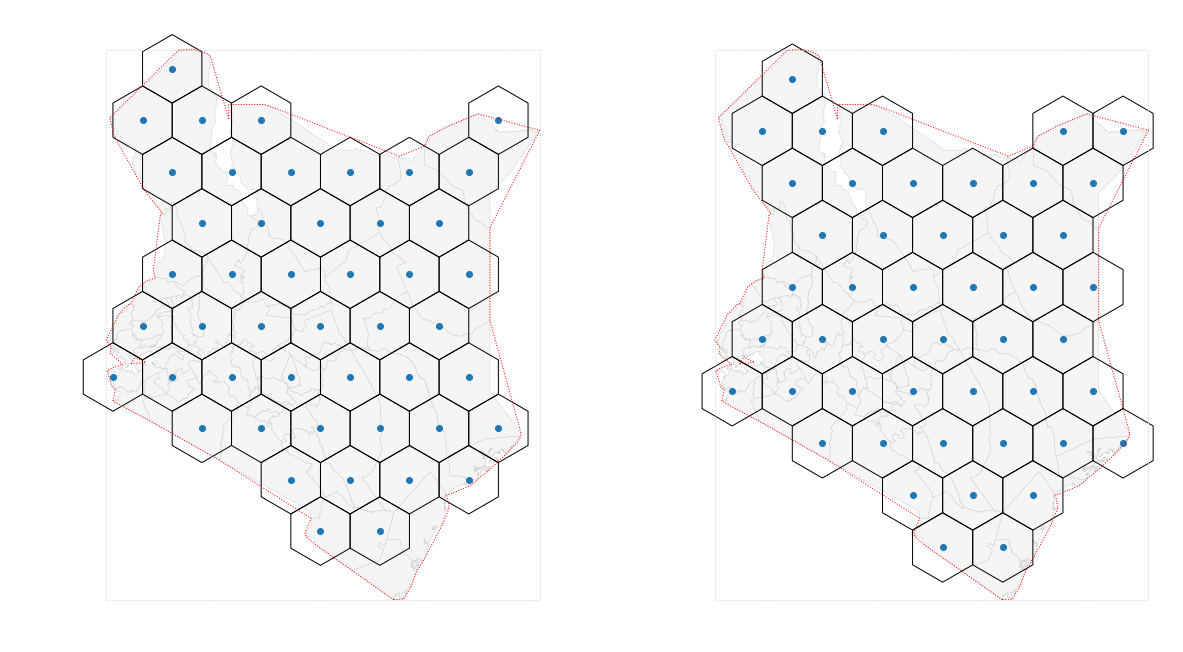

In [16]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 16), sharex=True, sharey=True)

# Plot on axis 1 (left)
ax1.set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax1, linewidth=0.5, edgecolor='lightgrey', color='whitesmoke')
hexagons1.set_geometry('geom_centroid').plot(ax=ax1)
hexagons1.plot(ax=ax1, edgecolor='black', facecolor="none")
bbox_gdf.plot(ax=ax1, facecolor="none", edgecolor='lightgrey', linestyle=':')
admin_hulls_dissolved.plot(ax=ax1, linewidth=1, edgecolor='red', facecolor='none', linestyle=':')
#pt.plot(ax=ax1, color='red')

# Plot on axis 2 (left)
ax2.set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax2, linewidth=0.5, edgecolor='lightgrey', color='whitesmoke')
hexagons2.set_geometry('geom_centroid').plot(ax=ax2)
hexagons2.plot(ax=ax2, edgecolor='black', facecolor="none")
bbox_gdf.plot(ax=ax2, facecolor="none", edgecolor='lightgrey', linestyle=':')
admin_hulls_dissolved.plot(ax=ax2, linewidth=1, edgecolor='red', facecolor='none', linestyle=':')

plt.show()

### Display two versions of hexagon maps again, with parameters listed, and filled hexagons to check for holes

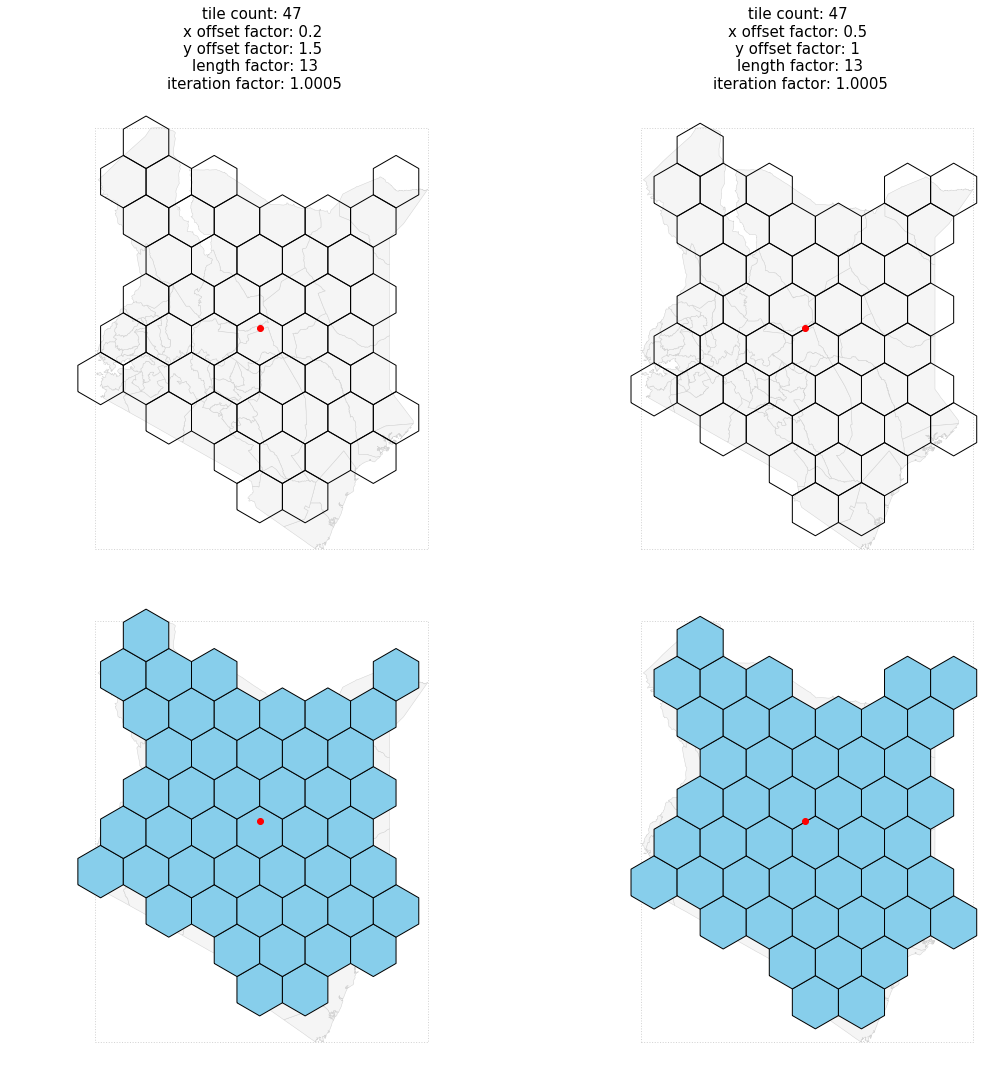

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(15, 15), sharex=True, sharey=True)

# Plot on axis 1 (top left)
ax[0,0].set_title('tile count: {} \nx offset factor: {} \ny offset factor: {} \nlength factor: {}\niteration factor: {}'.format(len(hexagons1), xofac1, yofac1, lfac, ifac), 
                  fontdict={'fontsize': '15', 'fontweight' : '500'})
ax[0,0].set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax[0,0], linewidth=0.5, edgecolor='lightgrey', color='whitesmoke')
bbox_gdf.plot(ax=ax[0,0], facecolor="none", edgecolor='lightgrey', linestyle=':')
hexagons1.plot(ax=ax[0,0], edgecolor='black', facecolor="none")
admin_hulls_dissolved.set_geometry('geom_centroid').plot(ax=ax[0,0], color='red')

# Plot on axis 2 (top right)
ax[0,1].set_title('tile count: {} \nx offset factor: {} \ny offset factor: {} \nlength factor: {}\niteration factor: {}'.format(len(hexagons2), xofac2, yofac2, lfac, ifac), 
                  fontdict={'fontsize': '15', 'fontweight' : '500'})
ax[0,1].set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax[0,1], linewidth=0.5, edgecolor='lightgrey', color='whitesmoke')
bbox_gdf.plot(ax=ax[0,1], facecolor="none", edgecolor='lightgrey', linestyle=':')
hexagons2.plot(ax=ax[0,1], edgecolor='black', facecolor="none")
admin_hulls_dissolved.set_geometry('geom_centroid').plot(ax=ax[0,1], color='red')

# Plot on axis 3 (bottom left)
ax[1,0].set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax[1,0], linewidth=0.5, edgecolor='lightgrey', color='whitesmoke')
bbox_gdf.plot(ax=ax[1,0], facecolor="none", edgecolor='lightgrey', linestyle=':')
hexagons1.plot(ax=ax[1,0], edgecolor='black', facecolor="skyblue")
admin_hulls_dissolved.set_geometry('geom_centroid').plot(ax=ax[1,0], color='red')

# Plot on axis 4 (bottom right)
ax[1,1].set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax[1,1], linewidth=0.5, edgecolor='lightgrey', color='whitesmoke')
bbox_gdf.plot(ax=ax[1,1], facecolor="none", edgecolor='lightgrey', linestyle=':')
hexagons2.plot(ax=ax[1,1], edgecolor='black', facecolor="skyblue")
admin_hulls_dissolved.set_geometry('geom_centroid').plot(ax=ax[1,1], color='red')

plt.show()

### Display the first hexagon map with tile numbers
* **Last two digits** = column number
* **First 1-2 digits** = row number

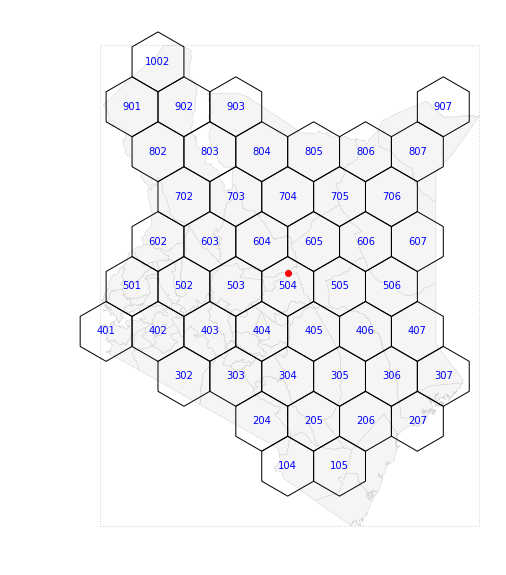

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))
ax.set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax, linewidth=0.5, 
                                     edgecolor='lightgrey', color='whitesmoke')
bbox_gdf.plot(ax=ax, facecolor="none", edgecolor='lightgrey', linestyle=':')
hexagons1.plot(ax=ax, edgecolor='black', facecolor="none")
admin_hulls_dissolved.set_geometry('geom_centroid').plot(ax=ax, color='red')
#hexagons1.set_geometry('geom_centroid').plot(ax=ax, color='lightblue')
#display_point_labels(admin.set_geometry('geom_centroid'), admin_id, c='black')
display_point_labels(hexagons1.set_geometry('geom_centroid'), tile_id)

#admin.set_geometry('geom_centroid').plot(ax=ax, color='green')

### Functions to calculate distance between a centroid (e.g. country centroid) and centroids of hexagons and admin polygons
* This allows us to rank order the hexagon tiles and admin polygons to assign admin names to hexagons 

In [20]:
def dist_to_centroid_fld(centers, centroid, idx_col, order_col, sort_order):
    distances = {}
    print(type(centroid['geom_centroid']))
    centroid_pt = centroid['geom_centroid'][0] #Get Shapely point geom from geodataframe
    
    try:
        centers.drop(columns=['dist_to_centroid', order_col], inplace=True)
    except:
        pass
        
    for i, row in centers.iterrows():
        pt = row['geom_centroid']
        idx = row[idx_col] 
        distance = pt.distance(centroid_pt)
        distances[idx] = distance
        #print('{}  {}  {}'.format(i, idx, distance))
    
    if sort_order == 'farthest_first':
        rev = True
    elif sort_order == 'closest_first':
        rev = False
        
    distances_dict = dict(sorted(distances.items(), key=operator.itemgetter(1), 
                                 reverse=rev))
    distances_df = pd.DataFrame(list(distances_dict.items()), 
                                columns=[idx_col, 'dist_to_centroid'])
    distances_df[order_col] = distances_df.index
    centers = centers.join(distances_df.set_index(idx_col), 
                           on=idx_col).sort_values(by=[order_col]).reset_index(drop=True)

    return centers

def build_admin_tile_distance_df(admin_centers, tile_centers):
    cols = [admin_id, tile_id, 'distance']
    df_dist = pd.DataFrame(columns=cols, dtype=int)
    
    for idx1, admin_row in admin_centers.iterrows():
        admin_pt = admin_row['geom_centroid']
        admin_idx = admin_row[admin_id]
        
        for idx2, tile_row in tile_centers.iterrows():
            tile_pt = tile_row['geom_centroid']
            tile_idx = tile_row[tile_id]
            distance = tile_pt.distance(admin_pt)
            #print(distance)
            
            df_tmp = pd.DataFrame([[admin_idx, tile_idx, distance]], columns=cols)
            df_dist = df_dist.append(df_tmp, ignore_index=True)
            
    return df_dist

admin = dist_to_centroid_fld(admin, admin_hulls_dissolved, admin_id, jo_admin, 'farthest_first')
hexagons1 = dist_to_centroid_fld(hexagons1, admin_hulls_dissolved, tile_id, jo_tile, 'farthest_first')

distance_df = build_admin_tile_distance_df(admin, hexagons1)

display(HTML(admin[[admin_id, jo_admin]].head(10).to_html()))
display(HTML(hexagons1[[tile_id, jo_tile]].head(10).to_html()))
#display(HTML(distance_df.head(50).to_html()))

# display(HTML(admin.head(3).to_html()))
# display(HTML(hexagons1.head(3).to_html()))


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


,admin_id,join_order_admin
0,MOMBASA,0
1,KWALE,1
2,KILIFI,2
3,TAITA TAVETA,3
4,MANDERA,4
5,LAMU,5
6,MIGORI,6
7,TURKANA,7
8,BUSIA,8
9,SIAYA,9


,tile_id,join_order_tile
0,1002,0
1,907,1
2,901,2
3,105,3
4,207,4
5,902,5
6,104,6
7,401,7
8,307,8
9,807,9


### Match hexagon tiles and admin names
**Two methods are used**
* admin-distance-to-centroid
* tile-distance-to-centroid prioritization

In [37]:
def match_one_to_another(admin_centers, tile_centers, dist_df, order_defined_by): 
    if order_defined_by == 'admin':
        cols = [admin_id_admin, tile_id]
        df_match = pd.DataFrame(columns=cols, dtype=int)
        
        for i, row in admin_centers[[admin_id, jo_admin]].iterrows():
            admin_idx = row[admin_id]
            df = dist_df.loc[dist_df[admin_id] == admin_idx]
            tile_idx = df.loc[df.groupby(admin_id)['distance'].idxmin()][tile_id].values[0]
            dist_df = dist_df[dist_df[tile_id] != tile_idx]

            df_tmp = pd.DataFrame([[admin_idx, tile_idx]], columns=cols)
            df_match = df_match.append(df_tmp, ignore_index=True)
    
    if order_defined_by == 'tile':
        cols = [admin_id_tile, tile_id]
        df_match = pd.DataFrame(columns=cols, dtype=int)
        
        for i, row in tile_centers[[tile_id, jo_tile]].iterrows():
            tile_idx = row[tile_id]
            df = dist_df.loc[dist_df[tile_id] == tile_idx]
            admin_idx = df.loc[df.groupby(tile_id)['distance'].idxmin()][admin_id].values[0]
            dist_df = dist_df[dist_df[admin_id] != admin_idx]

            df_tmp = pd.DataFrame([[admin_idx, tile_idx]], columns=cols)
            df_match = df_match.append(df_tmp, ignore_index=True)
            
    return df_match
    
farthest_states_match = match_one_to_another(admin, hexagons1, distance_df, 'admin')
farthest_tile_match = match_one_to_another(admin, hexagons1, distance_df, 'tile')

display(HTML(farthest_states_match.head(5).to_html()))
display(HTML(farthest_tile_match.head(5).to_html()))

hexagons1 = hexagons1.merge(farthest_states_match, on=tile_id)
hexagons1 = hexagons1.merge(farthest_tile_match, on=tile_id)

display(HTML(hexagons1.head(5).to_html()))

,admin_id_admin,tile_id
0,MOMBASA,105.0
1,KWALE,104.0
2,KILIFI,206.0
3,TAITA TAVETA,205.0
4,MANDERA,807.0


,admin_id_tile,tile_id
0,TURKANA,1002.0
1,MANDERA,907.0
2,WEST POKOT,901.0
3,TAITA TAVETA,105.0
4,LAMU,207.0


,geom_poly,tile_id,geom_centroid,dist_to_centroid,join_order_tile,admin_id_admin,admin_id_tile
0,"POLYGON ((3849779.194193602 534274.4951030157,...",1002,POINT (3910687.049153523 569439.6615590785),582832.973583,0,MERU,TURKANA
1,"POLYGON ((4519765.598725718 428778.9957366504,...",907,POINT (4580673.453685637 463944.1621927132),535590.427464,1,THARAKA NITHI,MANDERA
2,"POLYGON ((3788871.339236137 428778.9957366504,...",901,POINT (3849779.194196057 463944.1621927131),535504.620413,2,ISIOLO,WEST POKOT
3,POLYGON ((4276134.178895857 -415184.9991942716...,105,POINT (4337042.033855777 -380019.8327382088),468607.235651,3,MOMBASA,TAITA TAVETA
4,POLYGON ((4458857.743768252 -309689.4998279064...,207,POINT (4519765.598728172 -274524.3333718435),461715.136319,4,LAMU,LAMU


### Display named hexagons

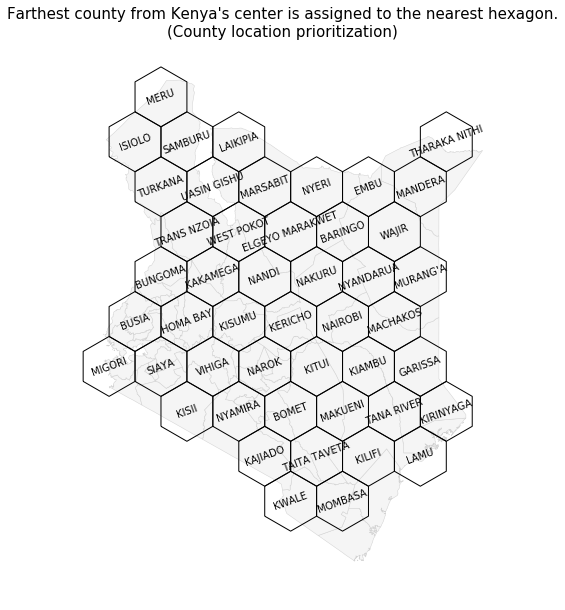

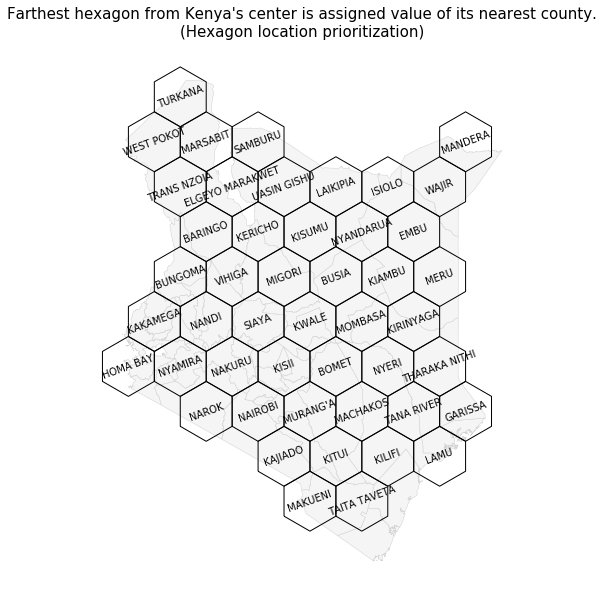

In [59]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(11, 10))
ax1.set_title('Farthest county from Kenya\'s center is assigned to the nearest hexagon.\n(County location prioritization)', 
                  fontdict={'fontsize': '15', 'fontweight' : '500'})
ax1.set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax1, linewidth=0.5, 
                                     edgecolor='lightgrey', color='whitesmoke')
#bbox_gdf.plot(ax=ax1, facecolor="none", edgecolor='lightgrey', linestyle=':')
hexagons1.plot(ax=ax1, edgecolor='black', facecolor="none")
hexagons1[tile_id] = hexagons1.index
display_point_labels(hexagons1.set_geometry('geom_centroid'), 
                     admin_id_admin, c='black', angle=20)


fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))
ax2.set_title('Farthest hexagon from Kenya\'s center is assigned value of its nearest county.\n(Hexagon location prioritization)', 
                  fontdict={'fontsize': '15', 'fontweight' : '500'})
ax2.set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax2, linewidth=0.5, 
                                     edgecolor='lightgrey', color='whitesmoke')
#bbox_gdf.plot(ax=ax2, facecolor="none", edgecolor='lightgrey', linestyle=':')
hexagons1.plot(ax=ax2, edgecolor='black', facecolor="none")
hexagons1[tile_id] = hexagons1.index
display_point_labels(hexagons1.set_geometry('geom_centroid'), 
                     admin_id_tile, c='black', angle=20)

plt.show()
#fig2.savefig('USA_hexes_labeled.png', bbox_inches='tight', dpi=300) # For saving the figure as a PNG

### Other fun map, to print and assign names by hand

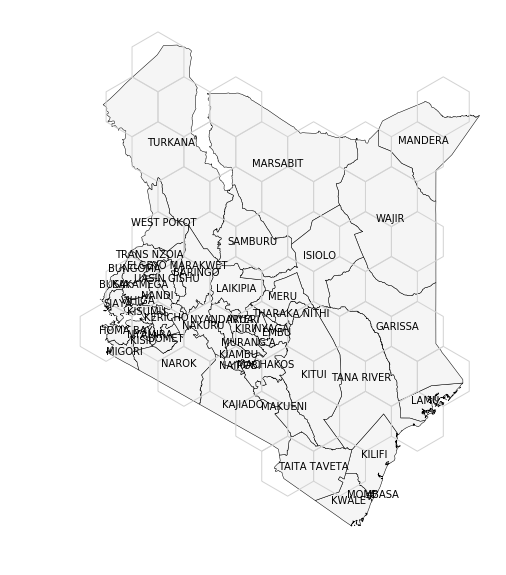

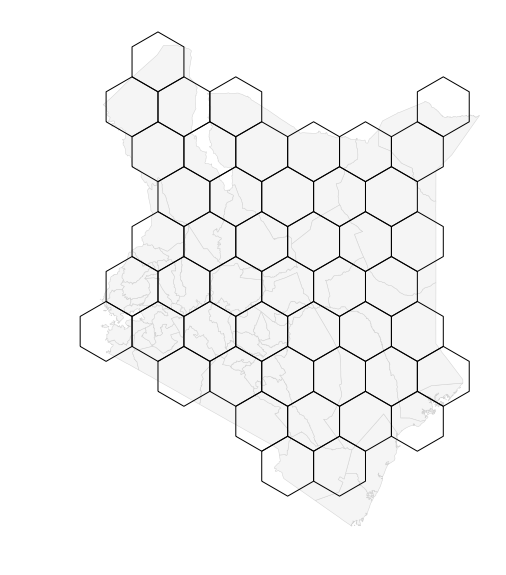

In [60]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))
#ax.set_title('States', 
#                  fontdict={'fontsize': '15', 'fontweight' : '500'})
ax.set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax, linewidth=0.5, 
                                     edgecolor='black', color='whitesmoke')
#bbox_gdf.plot(ax=ax, facecolor="none", edgecolor='lightgrey', linestyle=':')
hexagons1.plot(ax=ax, edgecolor='lightgrey', facecolor="none")
hexagons1[tile_id] = hexagons1.index
display_point_labels(admin.set_geometry('geom_centroid'), admin_id, c='black')



fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))
#ax2.set_title('Blank', 
#                  fontdict={'fontsize': '15', 'fontweight' : '500'})
ax2.set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax2, linewidth=0.5, 
                                     edgecolor='lightgrey', color='whitesmoke')
#bbox_gdf.plot(ax=ax2, facecolor="none", edgecolor='lightgrey', linestyle=':')
hexagons1.plot(ax=ax2, edgecolor='black', facecolor="none")
hexagons1[tile_id] = hexagons1.index

### Output hexagons to a GIS format

In [61]:
hexagons1.drop(columns=['geom_centroid']).to_file('Kenya_hexagons.geojson', driver='GeoJSON')
#hexagons1.drop(columns=['geom_centroid']).to_file('India_hexagons.shp', driver='ESRI Shapefile')

/anaconda3/envs/hexgrid/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
